In [1]:
import numpy as np
import random
import sys
import os

from pathlib import Path
import importlib
import utilities as us
importlib.reload(us)

# Add parent directory (where pygestalt lives) to sys.path
sys.path.append(os.path.abspath(".."))

import pygestalt as gs
from pygestalt import sampler

from matplotlib import pyplot as plt
from matplotlib.pyplot import *

import torch
import torch.nn as nn

In [2]:
kernel_tensor_1, angles = us.make_gabor_kernels(ksize=7, sigma=2, lam=4)
kernel_tensor_2, _ = us.make_gabor_kernels(ksize=31, sigma=5, lam=15)

In [8]:
outdir = Path(os.getcwd()) / 'outputs'
os.makedirs(outdir, exist_ok=True)

Ps = np.random.uniform(size=(4,2))
#Ps = np.vstack([[0.2,0], Ps, [0.8,1]])
#Ps = np.array([[0.,0.], [0.1,0.9], [0.9,0.1], [1.,1.]])
#Ps = np.array([[0.,0.], [1.,1.]])

radius = 0.02
thresh = 1e-3

%time C, H = sampler.draw_positions(radius, sampler.bezier_curve(Ps), thresh=thresh)
%time D, _ = sampler.draw_positions(radius, sampler.box(), exclusions=C, thresh=thresh)

CPU times: user 1.43 s, sys: 20.8 ms, total: 1.45 s
Wall time: 1.49 s
CPU times: user 20.3 s, sys: 118 ms, total: 20.4 s
Wall time: 20.5 s


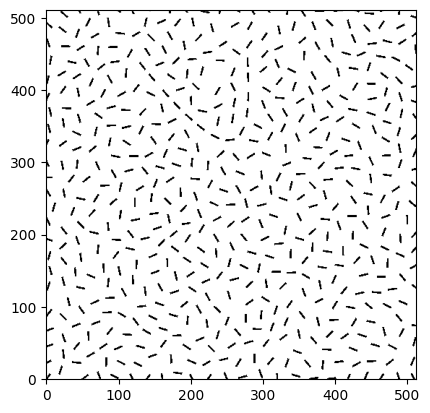

In [9]:
# Define the patch function

l=0.025
w=0.005
pfunc = lambda z,h: gs.patch.segment(z, h, l, w)

N = 512
If, Tf = gs.patch.generate_image(C, H, N=N, pfunc=pfunc)
Ig, Tg = gs.patch.generate_image(D, N=N, pfunc=pfunc)

I = If + Ig

#image = torch.tensor(Ig)
#image_tensor = image.unsqueeze(0).unsqueeze(0)

#image_tensor = image_tensor.to(torch.float32)
kernel_tensor_1 = kernel_tensor_1.to(torch.float32)
kernel_tensor_2 = kernel_tensor_2.to(torch.float32)

plt.imshow(I, aspect='equal',origin= "lower", cmap='binary')

In [ ]:
for i in range(10):

    # --- Convert Ig to torch tensor ---
    img_np = Ig
    img_tensor = torch.tensor(img_np, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    # --- First convolution ---
    conv1 = nn.functional.conv2d(
        img_tensor,
        kernel_tensor_1,
        stride=1,
        padding=3
    )

    # --- Second convolution ---
    conv2 = nn.functional.conv2d(
        conv1,
        kernel_tensor_2,
        stride=1,
        padding=15,
        groups=20
    )

    # --- Compute metrics of current Ig ---
    curr_mean = (conv2**2).mean(dim=[2, 3]).sum().item()
    curr_var = conv2.var(dim=[2, 3], unbiased=False).sum().item()

    # --- Build updated candidate image ---
    updated_img = img_np.copy()
    cluster_list = us.clusters(conv2)

    indices = random.sample(range(14), 7)

    for j in indices:
        val, ch_main, px, py = cluster_list[j]

        ch_weak, weak_val = us.weakest_channel(conv2, px, py)
        cx, cy = us.find_closest(img_np, px, py)
        connected = us.find_connected(img_np, cx, cy)
        outline = us.bounding_square(connected)
        x0, y0 = outline[0]
        x1, y1 = outline[1]

        patch = img_np[y0:y1, x0:x1].copy()
        angle = angles[ch_weak] - angles[ch_main] + random.uniform(-1, 1) * 0.1

        rotated = us.rotate_img(patch, angle)
        updated_img[y0:y1, x0:x1] = rotated

    # --- Recompute conv2d on the candidate image (ALLOWED) ---
    cand_tensor = torch.tensor(updated_img, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    
    cand_conv1 = nn.functional.conv2d(
        cand_tensor, kernel_tensor_1,
        stride=1, padding=3
    )

    cand_conv2 = nn.functional.conv2d(
        cand_conv1, kernel_tensor_2,
        stride=1, padding=15,
        groups=20
    )

    # Metrics of candidate image
    cand_mean = (cand_conv2**2).mean(dim=[2, 3]).sum().item()
    cand_var = cand_conv2.var(dim=[2, 3], unbiased=False).sum().item()

    # --- UPDATE ONLY IF IMPROVED ---
    if cand_mean < curr_mean and cand_var < curr_var:
        Ig = updated_img
        print(f"Iter {i+1}: UPDATE | mean {curr_mean:.3f} → {cand_mean:.3f}, var {curr_var:.3f} → {cand_var:.3f}")
    else:
        # No update, but NO FREEZE — next iteration still proceeds
        print(f"Iter {i+1}: NO UPDATE | mean={curr_mean:.3f}, var={curr_var:.3f}")

Iter 1: UPDATE | mean 4934.145 → 4930.727, var 4934.100 → 4930.682


In [10]:
for i in range(100):

    # --- Convert Ig to torch tensor ---
    img_np = Ig
    img_tensor = torch.tensor(img_np, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    # --- First convolution ---
    conv1 = nn.functional.conv2d(
        img_tensor,
        kernel_tensor_1,
        stride=1,
        padding=3
    )

    # --- Second convolution ---
    conv2 = nn.functional.conv2d(
        conv1,
        kernel_tensor_2,
        stride=1,
        padding=15,
        groups=20
    )

    # --- Compute metrics of current Ig ---
    curr_mean = (conv2**2).mean(dim=[2, 3]).sum().item()
    curr_var = conv2.var(dim=[2, 3], unbiased=False).sum().item()

    # --- Build updated candidate image ---
    updated_img = img_np.copy()
    cluster_list = us.clusters(conv2)

    indices = random.sample(range(14), 7)

    for j in indices:
        val, ch_main, px, py = cluster_list[j]

        ch_weak, weak_val = us.weakest_channel(conv2, px, py)
        cx, cy = us.find_closest(img_np, px, py)
        connected = us.find_connected(img_np, cx, cy)
        outline = us.bounding_square(connected)
        x0, y0 = outline[0]
        x1, y1 = outline[1]
        side = outline[2]

        if x0 >= 0 and y0 >= 0 and x1 < 512 and y1 < 512:
            print((x0, x1, y0, y1))
            angle = angles[ch_weak] + random.uniform(-1, 1) * 0.1
            patch = us.draw_segment(angle, side)
            updated_img[y0:y1, x0:x1] = patch

    # --- Recompute conv2d on the candidate image (ALLOWED) ---
    cand_tensor = torch.tensor(updated_img, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    
    cand_conv1 = nn.functional.conv2d(
        cand_tensor, kernel_tensor_1,
        stride=1, padding=3
    )

    cand_conv2 = nn.functional.conv2d(
        cand_conv1, kernel_tensor_2,
        stride=1, padding=15,
        groups=20
    )

    # Metrics of candidate image
    cand_mean = (cand_conv2**2).mean(dim=[2, 3]).sum().item()
    cand_var = cand_conv2.var(dim=[2, 3], unbiased=False).sum().item()

    # --- UPDATE ONLY IF IMPROVED ---
    if cand_mean < curr_mean and cand_var < curr_var:
        Ig = updated_img
        print(f"Iter {i+1}: UPDATE | mean {curr_mean:.3f} → {cand_mean:.3f}, var {curr_var:.3f} → {cand_var:.3f}")
    else:
        # No update, but NO FREEZE — next iteration still proceeds
        print(f"Iter {i+1}: NO UPDATE | mean={curr_mean:.3f}, var={curr_var:.3f}")


(368, 383, 453, 468)
(436, 450, 478, 492)
(476, 491, 434, 449)
Iter 1: UPDATE | mean 4947.627 → 4942.453, var 4947.529 → 4942.355
(303, 317, 354, 368)
(484, 499, 56, 71)
(171, 185, 172, 186)
(230, 243, 89, 102)
Iter 2: UPDATE | mean 4942.453 → 4932.248, var 4942.355 → 4932.150
(146, 161, 201, 216)
(258, 273, 254, 269)
(131, 146, 57, 72)
(351, 365, 157, 171)
Iter 3: UPDATE | mean 4932.248 → 4927.258, var 4932.150 → 4927.161
(172, 186, 433, 447)
(131, 145, 57, 71)
(152, 166, 181, 195)
Iter 4: UPDATE | mean 4927.258 → 4919.984, var 4927.161 → 4919.887
(410, 426, 483, 499)
(382, 398, 267, 283)
(404, 418, 115, 129)
(481, 495, 77, 91)
Iter 5: UPDATE | mean 4919.984 → 4919.271, var 4919.887 → 4919.173
(20, 36, 366, 382)
(330, 346, 259, 275)
(483, 499, 55, 71)
(40, 54, 206, 220)
Iter 6: UPDATE | mean 4919.271 → 4915.851, var 4919.173 → 4915.753
(149, 165, 427, 443)
(54, 69, 26, 41)
(56, 70, 222, 236)
Iter 7: UPDATE | mean 4915.851 → 4913.174, var 4915.753 → 4913.077
(315, 329, 405, 419)
(462, 

In [ ]:
#for i in range(100):

    # --- Convert Ig (numpy array?) to torch tensor ---
#    img_np = Ig
#    img_tensor = torch.tensor(img_np, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    # --- First convolution ---
#    conv1 = nn.functional.conv2d(
#        img_tensor,
#       kernel_tensor_1,
#        stride=1,
#        padding=3
#    )

    # --- Second convolution ---
#    conv2 = nn.functional.conv2d(
#        conv1,
#        kernel_tensor_2,
#        stride=1,
#       padding=15,
#        groups=20
#    )

    # --- Find best channel output / position ---
#    val, ch_main, px, py = us.cluster(conv2)

    # Weakest channel relative to that position
#   ch_weak, weak_val = us.weakest_channel(conv2, px, py)

    # Find nearest pixel in Ig
#    cx, cy = us.find_closest(img_np, px, py)

    # Find connected component
#    connected_line = us.find_connected(img_np, cx, cy)

    # Bounding square around it
#    outline = us.bounding_square(connected_line)
#    x0, y0 = outline[0]
#    x1, y1 = outline[1]
    
    # Extract the patch (numpy)
#    patch_np = img_np[y0:y1, x0:x1].copy()

    # Compute rotation angle
#    rotation_angle = angles[ch_weak] - angles[ch_main]

    # Rotate patch using your helper
#    rotated_patch = us.rotate_img(patch_np, rotation_angle)

    # Replace patch in new image
#    updated_img = img_np.copy()
#    updated_img[y0:y1, x0:x1] = rotated_patch

    # Update Ig for next iteration
#    Ig = updated_img

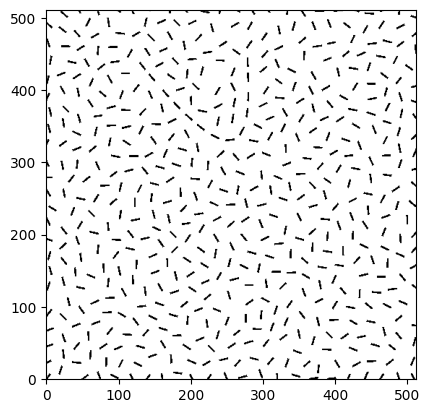

In [11]:
I = If + Ig

plt.imshow(I, aspect='equal',origin= "lower", cmap='binary')